# Satellite data 

This notebook loads Copernicus Marine daily L4 SST files (from `....ipynb`) and computes monthly SST anomalies, plus quick maps and a time series (2020-2024). (Might need to edit name opf the Copernicus SSt file)

Here I am looking at what satellite data says, I am considering at investigating SST, 


In [35]:
# 1) Imports
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

from pathlib import Path

# SST
Here I am looking at intraannual SST spatiotemporal variability

In [36]:
ds = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-sst_glo_phy_nrt_l4_P1D-m_2021-2024.nc")
ds

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 1461, latitude: 300, longitude: 500)
Coordinates:
  * latitude      (latitude) float32 1kB 40.05 40.15 40.25 ... 69.75 69.85 69.95
  * longitude     (longitude) float32 2kB -59.95 -59.85 -59.75 ... -10.15 -10.05
  * time          (time) datetime64[ns] 12kB 2021-01-01 ... 2024-12-31
Data variables:
    analysed_sst  (time, latitude, longitude) float64 2GB ...
Attributes:
    references:                Product User Manual for L4 Odyssea Product ove...
    Conventions:               CF-1.7, ACDD-1.3, ISO 8601
    history:                   Optimally interpolated SST originally produced...
    title:                     ODYSSEA Global Sea Surface Temperature Gridded...
    source:                    Odyssea L4 processor
    contact:                   emmanuelle.autret@ifremer.fr;jfpiolle@ifremer.fr
    institution:               Institut Francais de Recherche pour l'Exploita...
    copernicusmarine_version:  2.2.1

In [37]:
sst =ds['analysed_sst']
sst = sst - 273.15  # Convert from Kelvin to Celsius
sst = sst.rename('degC')  # Rename variable for convenience

### Cropping of study location
Not needed as data downloaded to exact location

In [38]:
# Example: same bounds as downloader
lat_name = "lat" if "lat" in sst.dims else "latitude"
lon_name = "lon" if "lon" in sst.dims else "longitude"

# If your longitude is 0..360 and you want negatives, you can convert once:
# if sst[lon_name].max() > 180:
#     sst = sst.assign_coords({lon_name: (((sst[lon_name] + 180) % 360) - 180)}).sortby(lon_name)

sst = sst.sel({lat_name: slice(55, 67), lon_name: slice(-36, -10)})
sst

<xarray.DataArray 'degC' (time: 1461, latitude: 120, longitude: 260)> Size: 365MB
array([[[ 6.11,  6.2 ,  6.29, ..., 10.14, 10.09, 10.04],
        [ 6.1 ,  6.19,  6.26, ..., 10.17, 10.13, 10.08],
        [ 6.07,  6.15,  6.21, ..., 10.2 , 10.16, 10.12],
        ...,
        [  nan,   nan,   nan, ...,  2.66,  2.66,  2.65],
        [  nan,   nan,   nan, ...,  2.57,  2.56,  2.54],
        [  nan,   nan,   nan, ...,  2.44,  2.43,  2.42]],

       [[ 6.1 ,  6.17,  6.24, ..., 10.11, 10.09, 10.04],
        [ 6.08,  6.16,  6.23, ..., 10.13, 10.11, 10.08],
        [ 6.07,  6.13,  6.2 , ..., 10.15, 10.14, 10.11],
        ...,
        [  nan,   nan,   nan, ...,  2.28,  2.27,  2.26],
        [  nan,   nan,   nan, ...,  2.22,  2.19,  2.15],
        [  nan,   nan,   nan, ...,  2.18,  2.14,  2.09]],

       [[ 6.18,  6.26,  6.32, ..., 10.19, 10.13, 10.04],
        [ 6.17,  6.24,  6.3 , ..., 10.21, 10.16, 10.09],
        [ 6.16,  6.23,  6.28, ..., 10.22, 10.19, 10.14],
        ...,
...
        [  nan,   nan,   nan, ...,  1.24,  1.33,  1.42],
        [  nan,   nan,   nan, ...,  1.21,  1.3 ,  1.41],
        [  nan,   nan,   nan, ...,  1.13,  1.18,  1.25]],

       [[ 8.07,  8.1 ,  8.15, ..., 11.21, 11.18, 11.16],
        [ 8.11,  8.13,  8.16, ..., 11.25, 11.22, 11.2 ],
        [ 8.08,  8.11,  8.13, ..., 11.21, 11.2 , 11.19],
        ...,
        [  nan,   nan,   nan, ...,  1.15,  1.24,  1.34],
        [  nan,   nan,   nan, ...,  1.1 ,  1.17,  1.28],
        [  nan,   nan,   nan, ...,  0.97,  1.03,  1.12]],

       [[ 7.92,  7.97,  8.01, ..., 11.2 , 11.17, 11.14],
        [ 7.93,  7.98,  8.01, ..., 11.21, 11.2 , 11.17],
        [ 7.92,  7.96,  8.  , ..., 11.2 , 11.19, 11.17],
        ...,
        [  nan,   nan,   nan, ...,  1.14,  1.24,  1.34],
        [  nan,   nan,   nan, ...,  1.03,  1.12,  1.22],
        [  nan,   nan,   nan, ...,  0.87,  0.91,  0.98]]],
      shape=(1461, 120, 260))
Coordinates:
  * latitude   (latitude) float32 480B 55.05 55.15 55.25 ... 66.75 66.85 66.95
  * longitude  (longitude) float32 1kB -35.95 -35.85 -35.75 ... -10.15 -10.05
  * time       (time) datetime64[ns] 12kB 2021-01-01 2021-01-02 ... 2024-12-31

### Calculating Monthly mean annomalies

In [39]:
# Monthly means, 12-month climatology, and seasonal anomalies
sst_mon = sst.resample(time='MS').mean()
clim12 = sst_mon.groupby('time.month').mean('time')           # (month, lat, lon)
annual_mean = clim12.mean('month')                             # (lat, lon)
seasonal_anom = clim12 - annual_mean                           # (month, lat, lon)

lon = sst[lon_name].values
lat = sst[lat_name].values

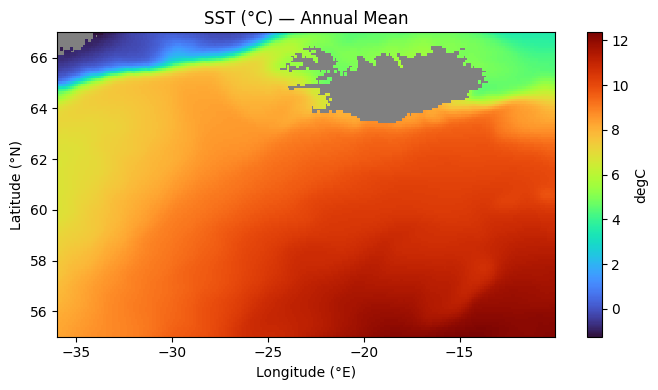

In [40]:
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolor(lon, lat, annual_mean.values, cmap='turbo')  # use cmocean.cm.thermal if available
plt.colorbar(cc, ax=ax, label='degC')
ax.set_title("SST (°C) — Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_20558/756512561.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


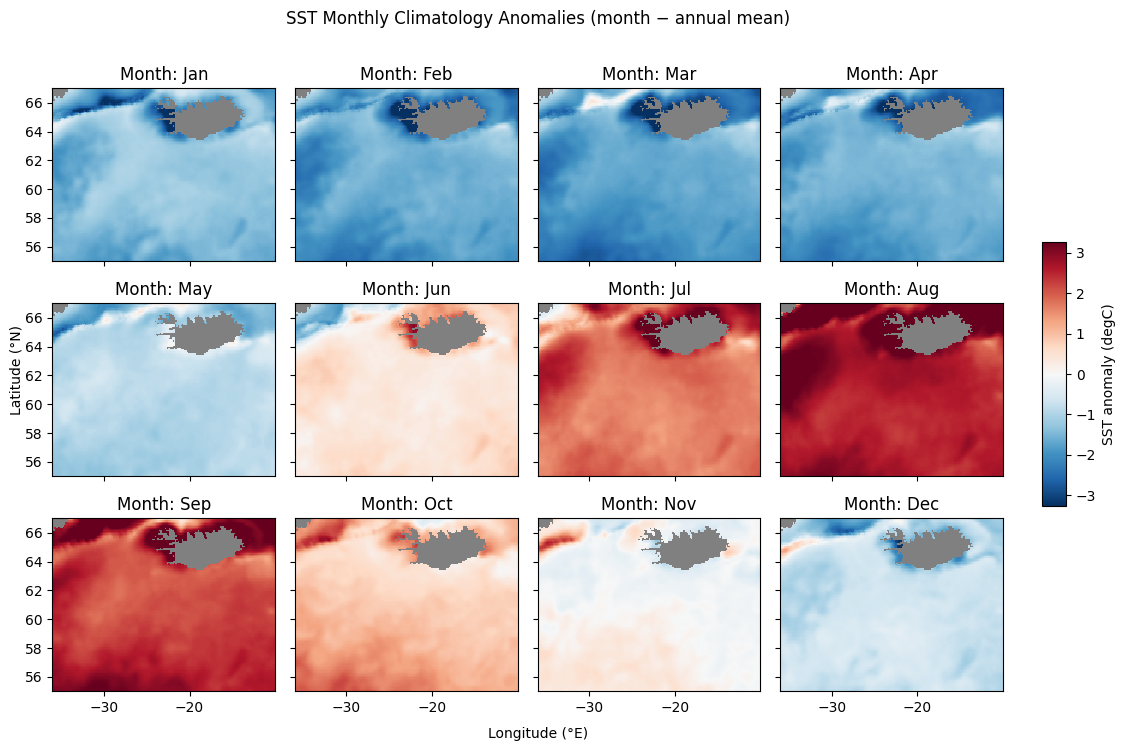

In [41]:
# Symmetric color scale using robust 98th percentile to avoid outliers
vlim = float(np.nanquantile(np.abs(seasonal_anom.values), 0.98))
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = seasonal_anom.isel(month=i).values
    cc_last = ax0.pcolor(lon, lat, da, cmap='RdBu_r', vmin=-vlim, vmax=+vlim)
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right, like the practical
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("SST anomaly (degC)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("SST Monthly Climatology Anomalies (month − annual mean)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()


# Chlorophyll 
Here a color estimated chlorophyll concentration data was used: https://data.marine.copernicus.eu/product/OCEANCOLOUR_GLO_BGC_L4_MY_009_104/download?dataset=cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_202311

In [42]:
dc = xr.open_dataset("../data/satellite/CMEMS_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D_2021-2024.nc")
dc
CHL = dc['CHL'] # Extracting Back scatter coefficient directly linked with chl concentrations
lat_name = "lat" if "lat" in CHL.dims else "latitude"
lon_name = "lon" if "lon" in CHL.dims else "longitude"

CHL = CHL.sel({lat_name: slice(55, 67), lon_name: slice(-35, -10)})

In [43]:
# Monthly means, 12-month climatology.
CHL_mon = CHL.resample(time='MS').mean()
CHL_clim12 = CHL_mon.groupby('time.month').mean('time')           # (month, lat, lon)
CHL_annual_mean = CHL_clim12.mean('month')                             # (lat, lon)

lon = CHL[lon_name].values
lat = CHL[lat_name].values

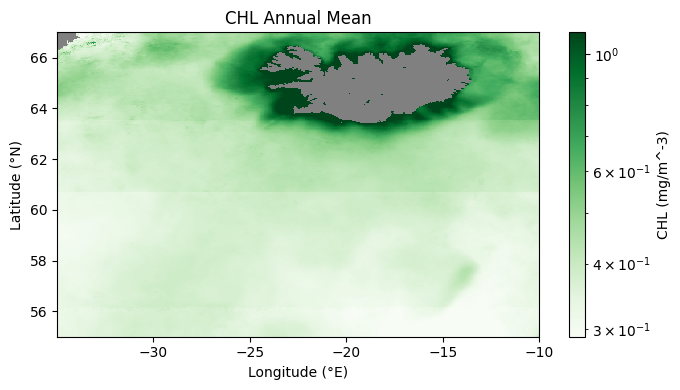

In [44]:
# Robust color scale for positive CHL values (log scale)
_vals = CHL_annual_mean.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_mean.values,
    cmap='Greens', norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL (mg/m^-3)')
ax.set_title("CHL Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_20558/2562950514.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


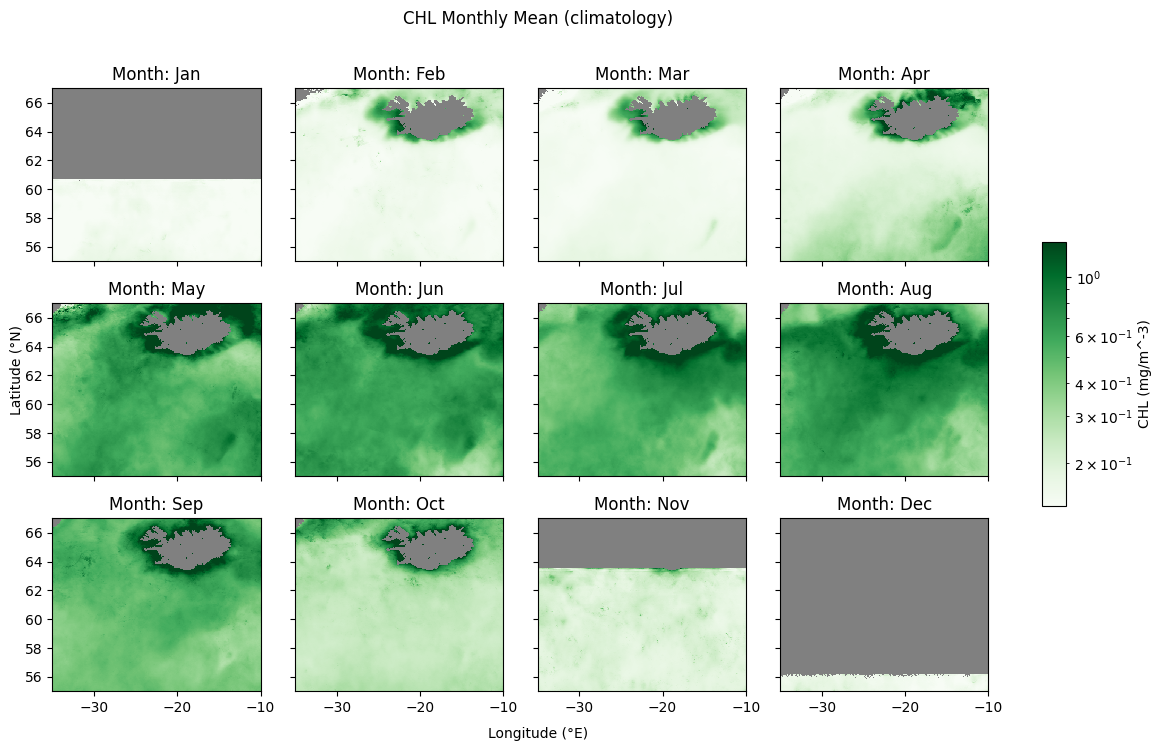

In [45]:
# Robust color scale for positive CHL values across all months (log scale)
_vals = CHL_clim12.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = CHL_clim12.isel(month=i).values
    cc_last = ax0.pcolormesh(
        lon, lat, da, cmap='Greens',
        norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
        shading='auto'
    )
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("CHL (mg/m^-3)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("CHL Monthly Mean (climatology)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()

## Bathymetry Data
Setting up bathymetry data withi the region

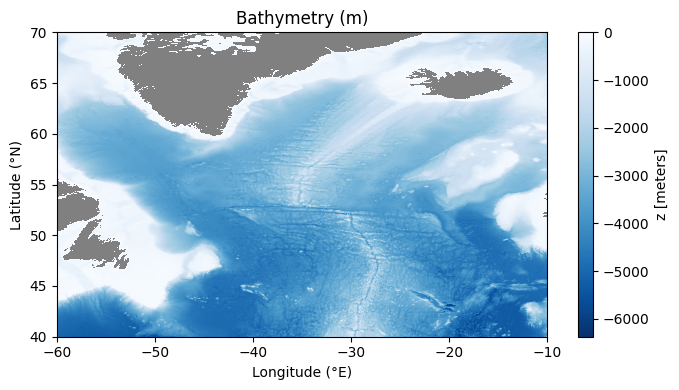

In [46]:
# Fetching BAthymetry Data

bathy = xr.open_dataset("../data/etopo1_subset.nc")

bathy = bathy.assign_coords(
    longitude=((bathy.longitude + 180) % 360) - 180
).sortby("longitude") # Convert from 0..360 to -180..180 if needed

bathy = bathy.where(bathy.z <= 0)  # Mask Surface areas

#PLoting Bathymetry
bathy.z.plot(figsize=(7,4), cmap='Blues_r')
plt.title("Bathymetry (m)")
plt.xlabel("Longitude (°E)")
plt.ylabel("Latitude (°N)")
plt.gca().set_facecolor("gray")
plt.tight_layout()
plt.show()

## Subdividing the region

Futher subdividing the region According to primeraly bathymetry, although I am looking into biogeochemical provences

(288, 600)
(4018, 288, 600)


/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_20558/2054748841.py:54: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(LON, LAT, Shape1, colors='blue', linewidths=1.5, linestyles='--', label='Shape 1')
/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_20558/2054748841.py:55: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(LON, LAT, Shape2, colors='orange', linewidths=1.5, linestyles='--', label='Shape 2')


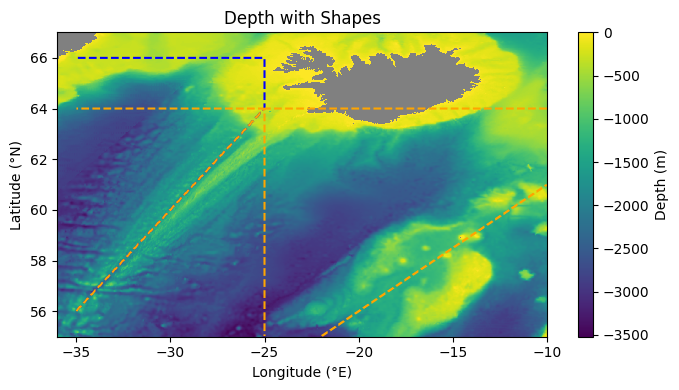

In [47]:
# Creating a matrice with the right cooridinates
LON, LAT = np.meshgrid(lon, lat)
print(LON.shape)
print(CHL.shape)

Shape1 = np.full(LON.shape, True)

#Creating a squares
# assuming you already have:
# LON, LAT = np.meshgrid(lon, lat)

lat_min = 56 + 0.8*(LON + 35)          # diagonal lower boundary

Shape1 = (
    (LON >= -35) & (LON <= -25) &      # between the longitudes
    (LAT >= lat_min) &                 # above the diagonal
    (LAT <= 66)                        # below 66°N
)

# Given LON, LAT from np.meshgrid(lon, lat)

# Lower boundary is piecewise by longitude:
#  -35..-25 : diagonal from (-35,56) to (-25,64)
#  -25..-22 : flat at 55
#  -22..-10 : diagonal from (-22,55) to (-10,61)
lat_lower = np.where(
    LON <= -25,
    56 + 0.8*(LON + 35),                 # slope = (64-56)/( -25 - (-35)) = 0.8
    np.where(
        LON <= -22,
        55.0,
        55 + 0.5*(LON + 22)              # slope = (61-55)/( -10 - (-22)) = 0.5
    )
)

# Upper boundary is flat at 64 everywhere inside
lat_upper = 64.0

# Valid longitude band for the polygon is [-35, -10]
Shape2 = (LON >= -35) & (LON <= -10) & (LAT >= lat_lower) & (LAT <= lat_upper)

bathy = bathy.sel(latitude=slice(55, 67), longitude=slice(-36, -10))

fig, ax = plt.subplots(figsize=(7,4))
cc = bathy.z.plot(ax=ax, x='longitude', y='latitude', add_colorbar=False)  # xarray handles coords
plt.colorbar(cc, ax=ax, label='Depth (m)')

ax.set_title("Depth with Shapes")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")

# Overlay your shapes (must match same coord system)
ax.contour(LON, LAT, Shape1, colors='blue', linewidths=1.5, linestyles='--', label='Shape 1')
ax.contour(LON, LAT, Shape2, colors='orange', linewidths=1.5, linestyles='--', label='Shape 2')

plt.tight_layout()
plt.show()

Shape1_CHL = CHL.where(Shape1)
Shape2_CHL = CHL.where(Shape2)


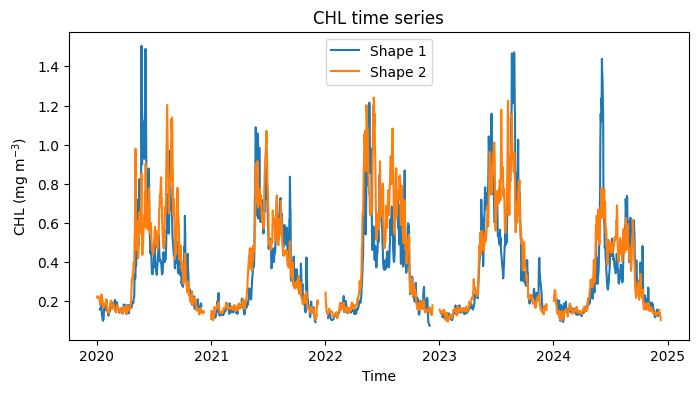

In [48]:
# Selecting data within this square


# Averaging data for linear time series and Plotting it
Shape1_ts = Shape1_CHL.mean(dim=("latitude", "longitude"), skipna=True)
Shape2_ts = Shape2_CHL.mean(dim=("latitude", "longitude"), skipna=True)

# Creating a Figure with Matplot rather then xarray

# Limitng time series to post 2020 data, to see better detail
Shape1_ts_post2020 = Shape1_ts.sel(time=slice("2020-01-01", None))
Shape2_ts_post2020 = Shape2_ts.sel(time=slice("2020-01-01", None))


fig, ax = plt.subplots(figsize=(8, 4))

Shape1_ts_post2020.plot(ax=ax, label="Shape 1")
Shape2_ts_post2020.plot(ax=ax, label="Shape 2")

ax.set_title("CHL time series")
ax.set_xlabel("Time")
ax.set_ylabel("CHL (mg m$^{-3}$)")
ax.legend()
plt.show()


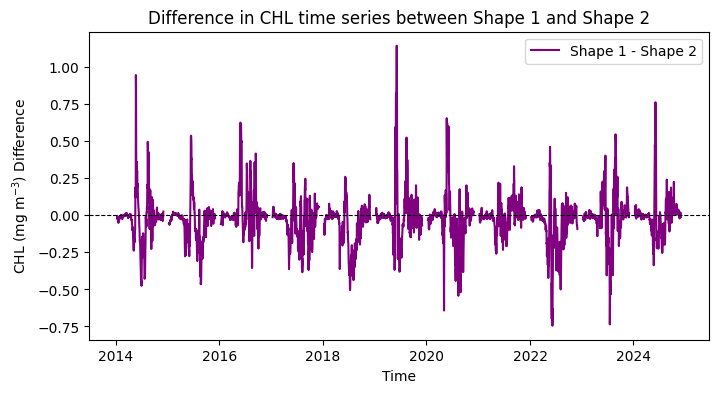

In [49]:
Difference = Shape1_ts - Shape2_ts



fig, ax = plt.subplots(figsize=(8, 4))

Difference.plot(ax=ax, color='purple', label="Shape 1 - Shape 2")
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
ax.set_title("Difference in CHL time series between Shape 1 and Shape 2")
ax.set_xlabel("Time")
ax.set_ylabel("CHL (mg m$^{-3}$) Difference")
ax.legend()
plt.show()

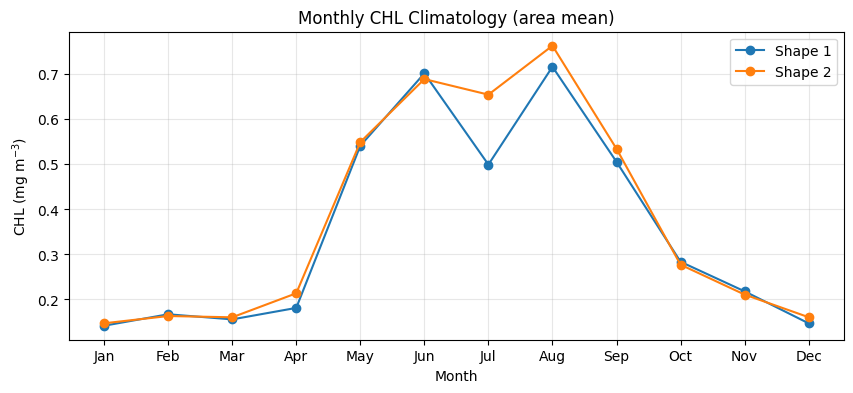

In [50]:
# Monthly Shape Climatology
Shape1_mon = Shape1_CHL.resample(time = 'MS').mean()
Shape1_clim12 = Shape1_mon.groupby('time.month').mean('time')
Shape1_annual_mean = Shape1_clim12.mean('month', skipna=True)

Shape2_mon = Shape2_CHL.resample(time = 'MS').mean()
Shape2_clim12 = Shape2_mon.groupby('time.month').mean('time')
Shape2_annual_mean = Shape2_clim12.mean('month', skipna=True)

# Creating Spatial mean 

Shape1_area_mean = Shape1_clim12.mean(dim=("latitude", "longitude"), skipna=True)
Shape2_area_mean = Shape2_clim12.mean(dim=("latitude", "longitude"), skipna=True)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(10, 4))

Shape1_area_mean.plot(ax=ax,marker = "o", label="Shape 1")
Shape2_area_mean.plot(ax=ax, marker = "o", label="Shape 2")

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel("CHL (mg m$^{-3}$)")
ax.set_title('Monthly CHL Climatology (area mean)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/xarray/core/dataset_utils.py:86: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/xarray/core/dataset_utils.py:86: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data


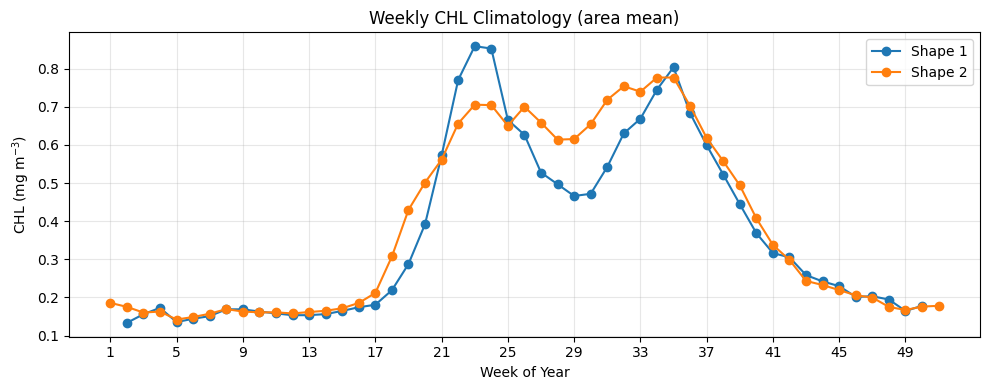

In [51]:
# Weekly Shape Climatology, (starting at Monday)
Shape1_wk = Shape1_CHL.resample(time='W-MON').mean()
Shape2_wk = Shape2_CHL.resample(time='W-MON').mean()

# Creating Weekly climatology across all years (1..53 possible)
Shape1_clim52 = Shape1_wk.groupby('time.week').mean('time')  # (week, lat, lon)
Shape2_clim52 = Shape2_wk.groupby('time.week').mean('time')

# Spatial mean to get 1D weekly series
Shape1_area_mean = Shape1_clim52.mean(dim=('latitude','longitude'), skipna=True)
Shape2_area_mean = Shape2_clim52.mean(dim=('latitude','longitude'), skipna=True)


# 4) Plot
fig, ax = plt.subplots(figsize=(10,4))
Shape1_area_mean.plot(ax=ax, marker='o', label='Shape 1')
Shape2_area_mean.plot(ax=ax, marker='o', label='Shape 2')

ax.set_title('Weekly CHL Climatology (area mean)')
ax.set_xlabel('Week of Year')
ax.set_ylabel('CHL (mg m$^{-3}$)')


ax.set_xticks(np.arange(1,53,4))  # tick every ~4 weeks for readability

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

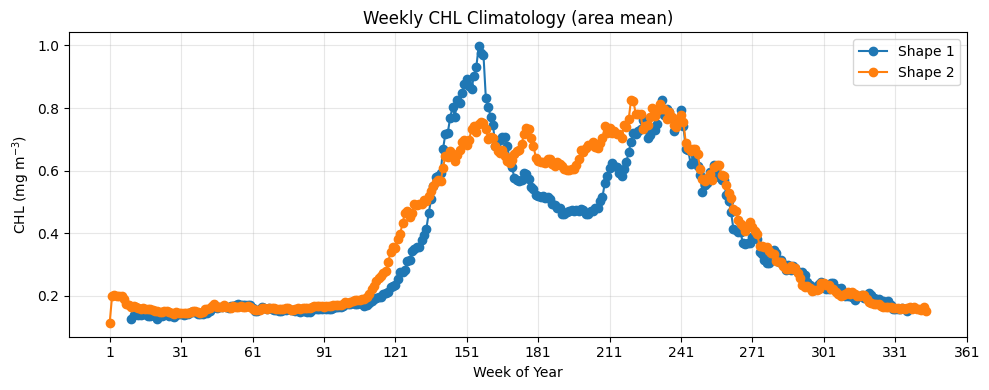

In [52]:
# Weekly Shape Climatology, (starting at Monday)

# Selecting by day, and assingning day a "day of the year"
Shape1_D = Shape1_CHL.resample(time='1D').mean()
Shape2_D = Shape2_CHL.resample(time='1D').mean()

Shape1_day = Shape1_D.assign_coords(doy=Shape1_D["time"].dt.dayofyear)
Shape2_day = Shape2_D.assign_coords(doy=Shape2_D["time"].dt.dayofyear)

# Creating Weekly climatology across all years (1..53 possible)
Shape1_clim365 = Shape1_day.groupby("doy").mean("time")
Shape2_clim365 = Shape2_day.groupby("doy").mean("time")

# Spatial mean to get 1D weekly series
Shape1_area_mean = Shape1_clim365.mean(dim=("latitude","longitude"), skipna=True)
Shape2_area_mean = Shape2_clim365.mean(dim=("latitude","longitude"), skipna=True)


# 4) Plot
fig, ax = plt.subplots(figsize=(10,4))
Shape1_area_mean.plot(ax=ax, marker='o', label='Shape 1')
Shape2_area_mean.plot(ax=ax, marker='o', label='Shape 2')

ax.set_title('Weekly CHL Climatology (area mean)')
ax.set_xlabel('Week of Year')
ax.set_ylabel('CHL (mg m$^{-3}$)')


ax.set_xticks(np.arange(1, 367, 30))

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

## Isoloating CHL using Bathymetry
Here I am isolating usin bathymetry data

In [53]:
# Iterpolating Bathymetry onto CHL grid and masking deep ocean

bathy_on_chl = bathy["z"].interp(
    longitude=CHL[lon_name],
    latitude=CHL[lat_name],
    method="linear",
)

# Isolating CHL using Bathymetry data in areas deeper than 1500m
CHL_deep_only = CHL.where(bathy_on_chl < -1500)

# Isolating data within shapes
Shape1_CHL = CHL_deep_only.where(Shape1)
Shape2_CHL = CHL_deep_only.where(Shape2)

In [54]:
# Monthly means, 12-month climatology.
CHL_mon = CHL_deep_only.resample(time='MS').mean()
CHL_clim12 = CHL_mon.groupby('time.month').mean('time')           # (month, lat, lon)
CHL_annual_mean = CHL_clim12.mean('month')                             # (lat, lon)

lon = CHL[lon_name].values
lat = CHL[lat_name].values

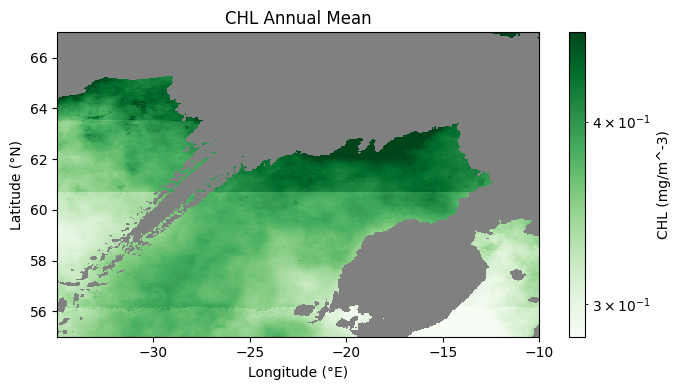

In [55]:
# Robust color scale for positive CHL values (log scale)
_vals = CHL_annual_mean.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
fig, ax = plt.subplots(figsize=(7,4))
cc = ax.pcolormesh(
    lon, lat, CHL_annual_mean.values,
    cmap='Greens', norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
    shading='auto'
)
plt.colorbar(cc, ax=ax, label='CHL (mg/m^-3)')
ax.set_title("CHL Annual Mean")
ax.set_xlabel("Longitude (°E)")
ax.set_ylabel("Latitude (°N)")
ax.set_facecolor("gray")
plt.tight_layout()
plt.show()

/var/folders/41/myncq97s4xl5mbkb4dncs48r0000gn/T/ipykernel_20558/3998593561.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])


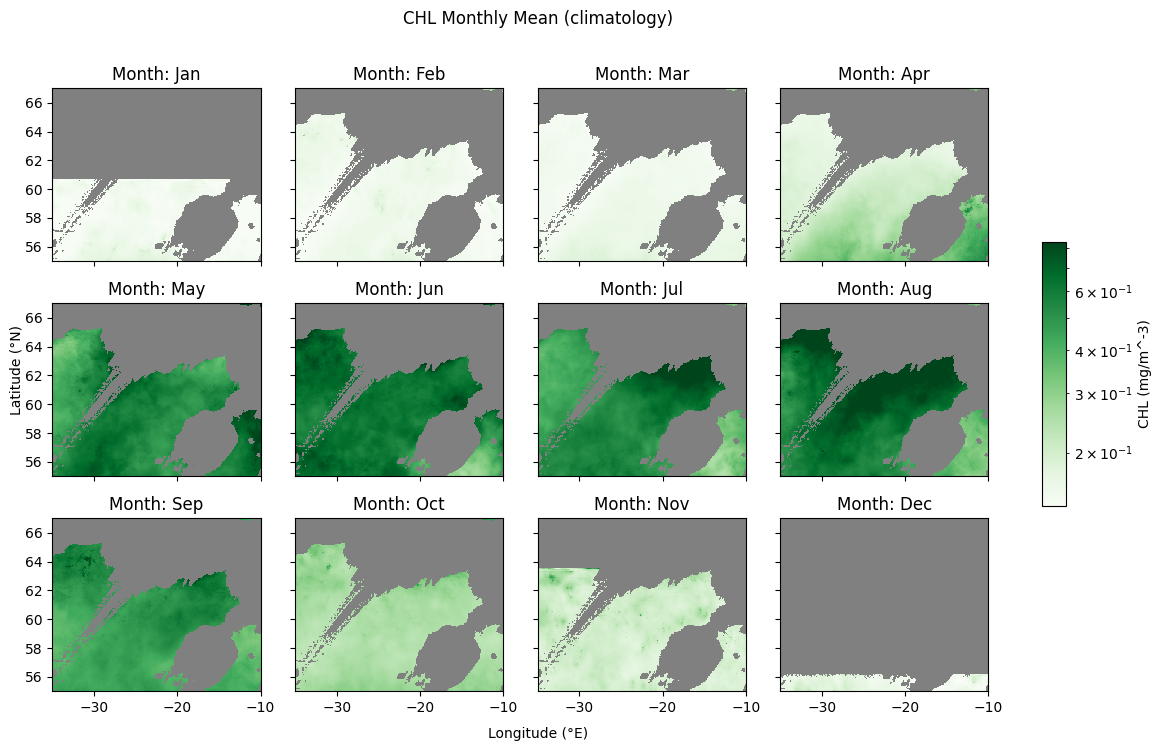

In [56]:

# Robust color scale for positive CHL values across all months (log scale)
_vals = CHL_clim12.values
_pos = _vals[(np.isfinite(_vals)) & (_vals > 0)]
_vmin, _vmax = np.nanquantile(_pos, [0.02, 0.98])
months_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(12,8))
cc_last = None
for i, ax0 in enumerate(ax.ravel()):
    da = CHL_clim12.isel(month=i).values
    cc_last = ax0.pcolormesh(
        lon, lat, da, cmap='Greens',
        norm=colors.LogNorm(vmin=float(_vmin), vmax=float(_vmax)),
        shading='auto'
    )
    ax0.set_title(f"Month: {months_labels[i]}")
    ax0.set_facecolor("gray")

# Colorbar on the right
axcb = fig.add_axes([0.92, 0.33, 0.02, 0.33])
cb = plt.colorbar(cc_last, cax=axcb)
cb.set_label("CHL (mg/m^-3)")

# Shared labels
fig.text(0.5, 0.04, "Longitude (°E)", ha='center')
fig.text(0.06, 0.5, "Latitude (°N)", va='center', rotation='vertical')
fig.suptitle("CHL Monthly Mean (climatology)", y=0.95)
plt.tight_layout(rect=[0.06, 0.05, 0.9, 0.94])
plt.show()

### Recreating Graphs

Comparing Two full Basins

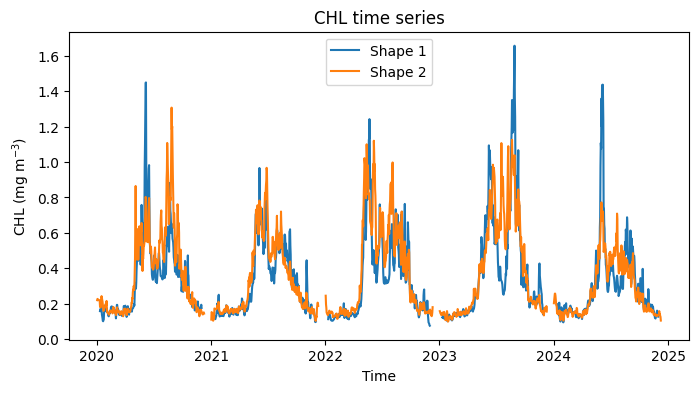

In [57]:
# Selecting data within this square


# Averaging data for linear time series and Plotting it
Shape1_ts = Shape1_CHL.mean(dim=("latitude", "longitude"), skipna=True)
Shape2_ts = Shape2_CHL.mean(dim=("latitude", "longitude"), skipna=True)

# Creating a Figure with Matplot rather then xarray

# Limitng time series to post 2020 data, to see better detail
Shape1_ts_post2020 = Shape1_ts.sel(time=slice("2020-01-01", None))
Shape2_ts_post2020 = Shape2_ts.sel(time=slice("2020-01-01", None))


fig, ax = plt.subplots(figsize=(8, 4))

Shape1_ts_post2020.plot(ax=ax, label="Shape 1")
Shape2_ts_post2020.plot(ax=ax, label="Shape 2")

ax.set_title("CHL time series")
ax.set_xlabel("Time")
ax.set_ylabel("CHL (mg m$^{-3}$)")
ax.legend()
plt.show()


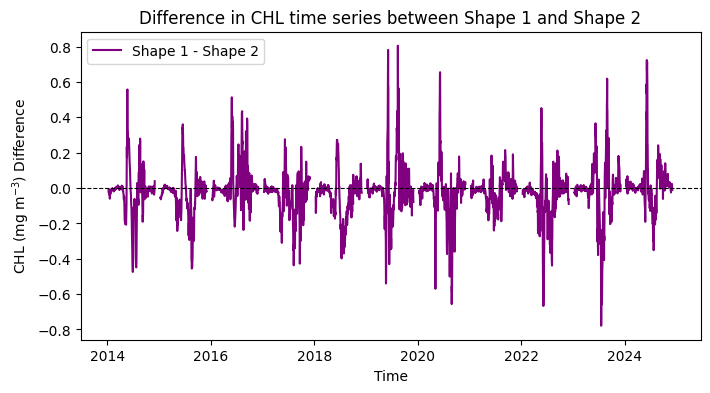

In [58]:
Difference = Shape1_ts - Shape2_ts



fig, ax = plt.subplots(figsize=(8, 4))

Difference.plot(ax=ax, color='purple', label="Shape 1 - Shape 2")
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
ax.set_title("Difference in CHL time series between Shape 1 and Shape 2")
ax.set_xlabel("Time")
ax.set_ylabel("CHL (mg m$^{-3}$) Difference")
ax.legend()
plt.show()

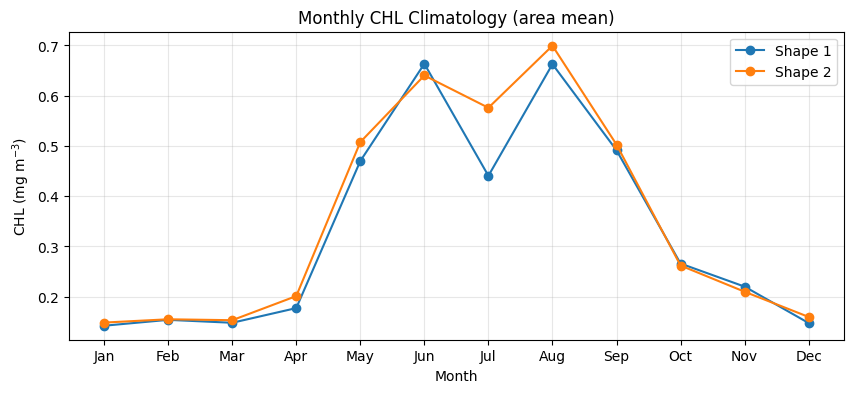

/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/xarray/core/dataset_utils.py:86: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data
/Users/davidlewis/Desktop/Masters/venv/lib/python3.12/site-packages/xarray/core/dataset_utils.py:86: FutureWarning: dt.weekofyear and dt.week have been deprecated. Please use dt.isocalendar().week instead.
  data = getattr(ref_var.dt, var_name).data


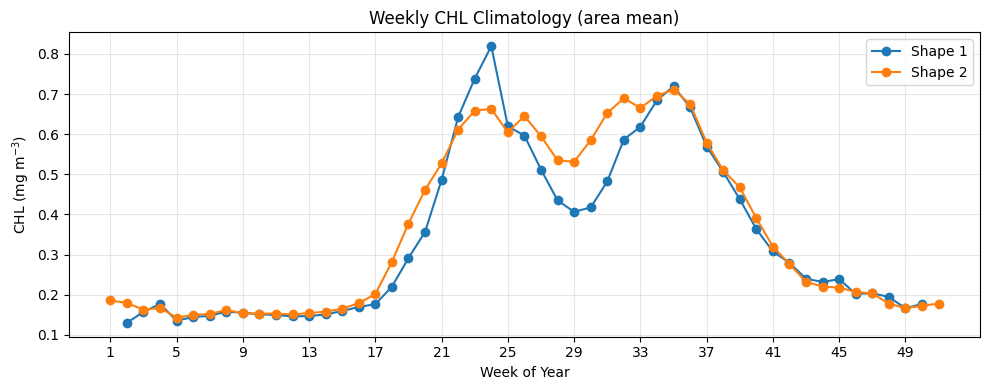

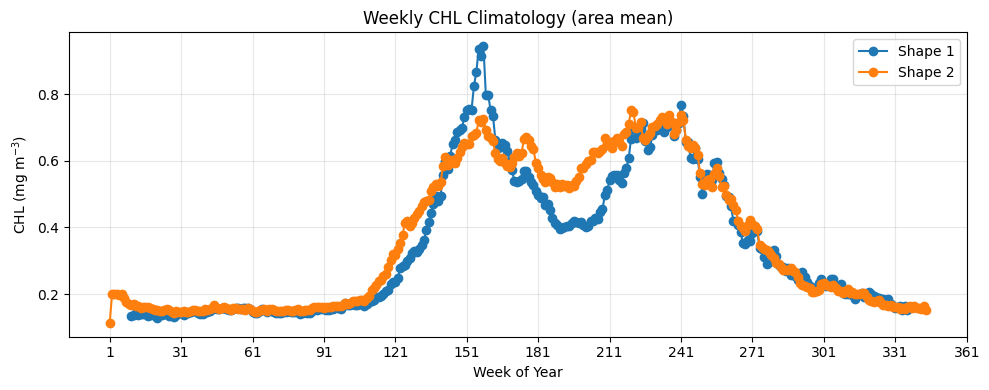

In [61]:
# Monthly Shape Climatology
Shape1_mon = Shape1_CHL.resample(time = 'MS').mean()
Shape1_clim12 = Shape1_mon.groupby('time.month').mean('time')
Shape1_annual_mean = Shape1_clim12.mean('month', skipna=True)

Shape2_mon = Shape2_CHL.resample(time = 'MS').mean()
Shape2_clim12 = Shape2_mon.groupby('time.month').mean('time')
Shape2_annual_mean = Shape2_clim12.mean('month', skipna=True)

# Creating Spatial mean 

Shape1_area_mean = Shape1_clim12.mean(dim=("latitude", "longitude"), skipna=True)
Shape2_area_mean = Shape2_clim12.mean(dim=("latitude", "longitude"), skipna=True)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(10, 4))

Shape1_area_mean.plot(ax=ax,marker = "o", label="Shape 1")
Shape2_area_mean.plot(ax=ax, marker = "o", label="Shape 2")

ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months)
ax.set_xlabel('Month')
ax.set_ylabel("CHL (mg m$^{-3}$)")
ax.set_title('Monthly CHL Climatology (area mean)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

# Weekly Shape Climatology, (starting at Monday)
Shape1_wk = Shape1_CHL.resample(time='W-MON').mean()
Shape2_wk = Shape2_CHL.resample(time='W-MON').mean()

# Creating Weekly climatology across all years (1..53 possible)
Shape1_clim52 = Shape1_wk.groupby('time.week').mean('time')  # (week, lat, lon)
Shape2_clim52 = Shape2_wk.groupby('time.week').mean('time')

# Spatial mean to get 1D weekly series
Shape1_area_mean = Shape1_clim52.mean(dim=('latitude','longitude'), skipna=True)
Shape2_area_mean = Shape2_clim52.mean(dim=('latitude','longitude'), skipna=True)


# 4) Plot
fig, ax = plt.subplots(figsize=(10,4))
Shape1_area_mean.plot(ax=ax, marker='o', label='Shape 1')
Shape2_area_mean.plot(ax=ax, marker='o', label='Shape 2')

ax.set_title('Weekly CHL Climatology (area mean)')
ax.set_xlabel('Week of Year')
ax.set_ylabel('CHL (mg m$^{-3}$)')


ax.set_xticks(np.arange(1,53,4))  # tick every ~4 weeks for readability

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Weekly Shape Climatology, (starting at Monday)

# Selecting by day, and assingning day a "day of the year"
Shape1_D = Shape1_CHL.resample(time='1D').mean()
Shape2_D = Shape2_CHL.resample(time='1D').mean()

Shape1_day = Shape1_D.assign_coords(doy=Shape1_D["time"].dt.dayofyear)
Shape2_day = Shape2_D.assign_coords(doy=Shape2_D["time"].dt.dayofyear)

# Creating Weekly climatology across all years (1..53 possible)
Shape1_clim365 = Shape1_day.groupby("doy").mean("time")
Shape2_clim365 = Shape2_day.groupby("doy").mean("time")

# Spatial mean to get 1D weekly series
Shape1_area_mean = Shape1_clim365.mean(dim=("latitude","longitude"), skipna=True)
Shape2_area_mean = Shape2_clim365.mean(dim=("latitude","longitude"), skipna=True)


# 4) Plot
fig, ax = plt.subplots(figsize=(10,4))
Shape1_area_mean.plot(ax=ax, marker='o', label='Shape 1')
Shape2_area_mean.plot(ax=ax, marker='o', label='Shape 2')

ax.set_title('Weekly CHL Climatology (area mean)')
ax.set_xlabel('Week of Year')
ax.set_ylabel('CHL (mg m$^{-3}$)')


ax.set_xticks(np.arange(1, 367, 30))

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()